In [ ]:
!pip install transformers pyreadstat

# Neural Network V3.0 Roberta-latest with Label

This notebook implements a neural network to predict the labels of a tweet (positive, negative ou neutral).

<b>Problem type</b> : <u>multi-label</u>

<b>Neural network used</b> : Transformer with Roberta-tweet-latest for sentiment analysis

<b>Training method</b> : K-fold validation

In [ ]:
%reset -f

## 1. Modules and data imports

In [ ]:
# Libraries imports

import os
import pandas as pd
import tensorflow as tf
import numpy as np
import transformers
import random as rd
import matplotlib.pyplot as plt
import keras.backend as K
import seaborn as sns
import warnings
from numpy.random import seed
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import AutoTokenizer
from transformers import TFAutoModel
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')

In [ ]:
def set_seed(seed: int = 42) -> None:
    rd.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    # When running on the CuDNN backend, two further options must be set
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_DISABLE_SEGMENT_REDUCTION_OP_DETERMINISM_EXCEPTIONS'] = '1'
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [ ]:
set_seed(42)

Random seed set as 42


In [ ]:
# Data import
df = pd.read_spss("/content/drive/MyDrive/VA_EN_TU_2012-2020_3000_tweets_relevant_V03_labeled_1200_cleaned.sav")


## Global Constants

In [ ]:
# Constants

nb_samples = len(df) # Number of tweets
proportion_training = 0.80 # 80/20 ratio : 80% of training data for k-fold validation, 20% for test data
pretrained_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest" # Roberta model for sentiment
seq_len = 131 # tweet length
batch_size = 80
learning_rate = 0.001 #0.0001
nb_epoch = 60
nb_fold = 3
earlyStopPatience = 10

## 2. Data processing

In [ ]:
def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=seq_len,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
# Preprocessing all data with Roberta's tokenizer
X_ids = np.zeros((len(df),seq_len))
X_mask = np.zeros((len(df),seq_len))

for i, sentence in enumerate(df['text']):
    X_ids[i, :], X_mask[i, :] = tokenize(sentence)

In [ ]:
sep = round(proportion_training * len(df))
labels = df[['Label_A2_negative', 'Label_A3_neutral','Label_A1_positive']].values

# Creating training data
X_ids_train = X_ids[:sep,:]
X_mask_train = X_mask[:sep,:]
Y_train = labels[:sep,:]

# Creating test data
X_ids_test = X_ids[sep:,:]
X_mask_test = X_mask[sep:,:]
Y_test = labels[sep:,:]

## 3. Metrics

In [ ]:
#------------------------STEP 1 --------------------------------#

# Metric1 construction to compute the % of success tweet by tweet

def metric1(y_true, y_pred):
    n = K.cast(K.shape(y_true)[0], 'float32')
    y_pred = K.reshape(y_pred,(n,1))
    res = K.equal(y_true,y_pred)
    res = K.cast(res, 'float32')
    res = K.sum(res) / n
    return res

In [ ]:
#------------------------STEP 2 --------------------------------#

# Metric2 construction to compute the % of success label by label
# (equal to binary-accuracy)

def metric2(y_true, y_pred):
    n = K.cast(K.shape(y_true)[0], 'float32')
    y_pred_r = K.round(y_pred)
    res = abs(y_true - y_pred_r)
    count_error = K.sum(K.cast(K.equal(res, 1), 'float32'),axis=0)
    res = 1-count_error / n
    res = K.mean(res)
    return res

## 4. Model construction

In [ ]:
# Loading pretrained model
pretrained_model = TFAutoModel.from_pretrained(pretrained_model_name)

tf_model.h5:   0%|          | 0.00/499M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
def get_model():

    input_text_ids = keras.Input(shape=(seq_len,), dtype='int32', name='input_text_ids')
    text_mask = keras.Input(shape=(seq_len,), dtype='int32', name='attention_mask_text')

    embeddings = pretrained_model(input_text_ids, attention_mask=text_mask)[1]

    x = tf.keras.layers.BatchNormalization()(embeddings)
    x = tf.keras.layers.GaussianNoise(0.2)(x)
    x = tf.keras.layers.Dense(512, activation='selu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='selu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='selu')(x)
    x = tf.keras.layers.Dropout(0.35)(x)
    x = tf.keras.layers.GaussianNoise(0.2)(x)

    predictions = layers.Dense(3, activation="sigmoid", name="predictions")(x)

    model = keras.Model(inputs=[input_text_ids,text_mask], outputs=predictions)

    model.layers[2].trainable = False # freeze pretrained model layer

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss="binary_crossentropy",
                metrics=["accuracy"])
    return model

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_text_ids (InputLayer  [(None, 131)]                0         []                            
 )                                                                                                
                                                                                                  
 attention_mask_text (Input  [(None, 131)]                0         []                            
 Layer)                                                                                           
                                                                                                  
 tf_roberta_model_15 (TFRob  TFBaseModelOutputWithPooli   1246456   ['input_text_ids[0][0]',      
 ertaModel)                  ngAndCrossAttentions(last_   32         'attention_mask_text[0

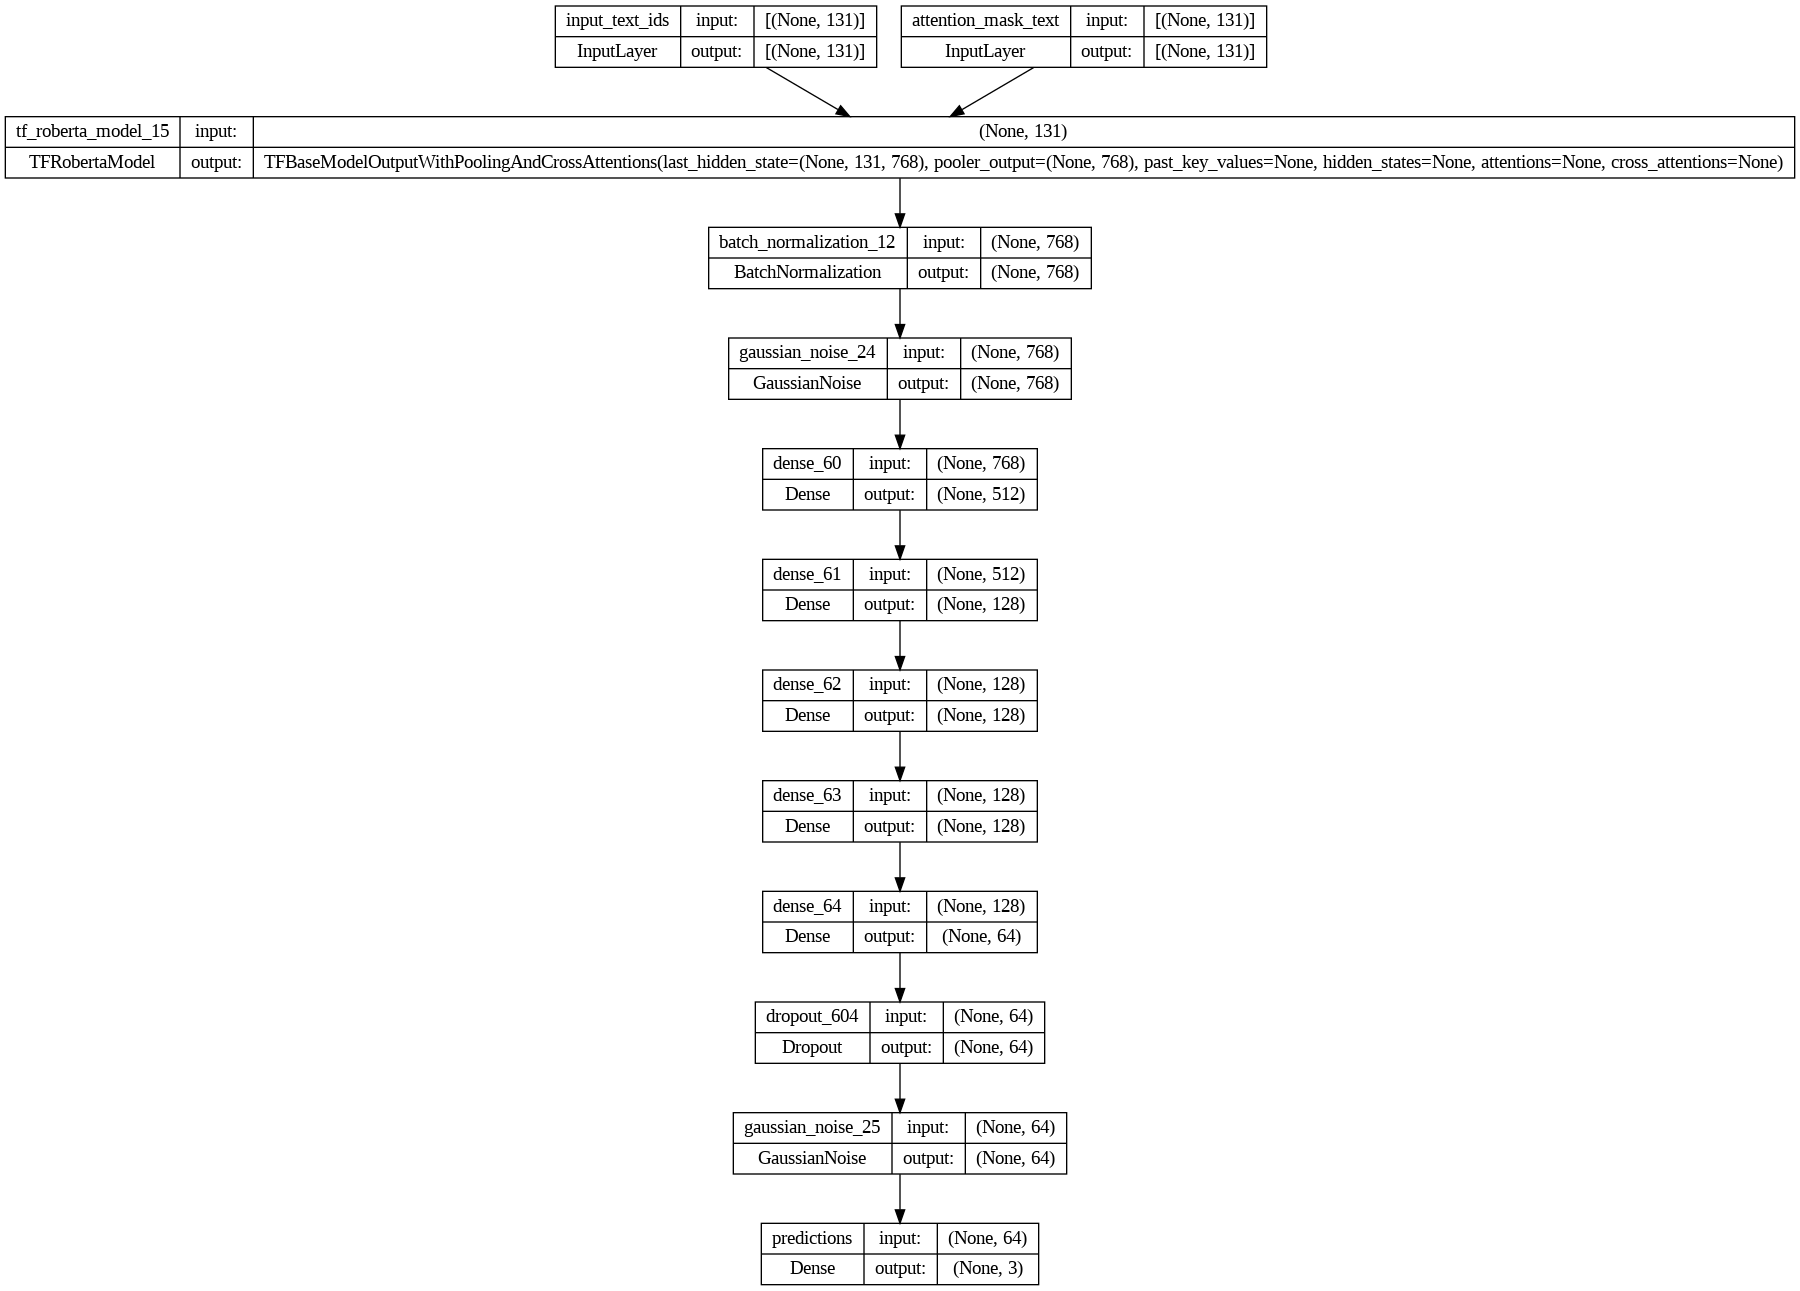

In [ ]:
model = get_model() # model construction
# model visualization
model.summary()
plot_model(model,show_shapes=True)

## 5. Training the model

In [ ]:
def fit_the_model(model, X_tr, y_tr, X_val, y_val, num):
    # The model is trained on data input X_tr, y_tr, having X_val, y_val as validation data
    callbacks = [
        EarlyStopping(monitor="val_metric2", patience=earlyStopPatience, mode="max"),
        ModelCheckpoint(filepath="MODEL/best_model"+str(num)+".hdf5", monitor="val_accuracy", mode='max', save_best_only=True, verbose=1)
    ]
    model.fit(X_tr, y_tr, validation_data = (X_val,y_val), epochs=nb_epoch, verbose=1, callbacks=callbacks, batch_size=batch_size)
    return model

In [ ]:
list_of_models = [] # To save models
list_history = [] # To save model efficiency

kfold = KFold(n_splits=nb_fold, shuffle=True, random_state=42)

# Training with k-fold method
k = 1
for train_index, val_index in kfold.split(X_ids_train,Y_train):
    print(f'\nTraining model {k}...')
    model = get_model() # Model construction
    history = fit_the_model(model,
                            [X_ids_train[train_index],
                             X_mask_train[train_index]],
                            Y_train[train_index],
                            [X_ids_train[val_index],
                             X_mask_train[val_index]],
                            Y_train[val_index], k) # Model training
    list_of_models.append(history)
    list_history.append(history.history.history)
    k += 1

print("---Finished---")


Training model 1...
Epoch 1/60
8/8 [==============================] - ETA: 0s - loss: 0.7373 - accuracy: 0.4922


Epoch 1: val_accuracy improved from -inf to 0.51724, saving model to MODEL/best_model1.hdf5
8/8 [==============================] - 33s 2s/step - loss: 0.7373 - accuracy: 0.4922 - val_loss: 0.5928 - val_accuracy: 0.5172
Epoch 2/60
8/8 [==============================] - ETA: 0s - loss: 0.6421 - accuracy: 0.5533


Epoch 2: val_accuracy improved from 0.51724 to 0.52351, saving model to MODEL/best_model1.hdf5
8/8 [==============================] - 17s 2s/step - loss: 0.6421 - accuracy: 0.5533 - val_loss: 0.5912 - val_accuracy: 0.5235
Epoch 3/60
8/8 [==============================] - ETA: 0s - loss: 0.5994 - accuracy: 0.5987


Epoch 3: val_accuracy did not improve from 0.52351
8/8 [==============================] - 11s 1s/step - loss: 0.5994 - accuracy: 0.5987 - val_loss: 0.6056 - val_accuracy: 0.5047
Epoch 4/60
8/8 [==============================] - ETA: 0s - loss: 0.6190 - accuracy: 0.5846


Epoch 4: val_accuracy did not improve from 0.52351
8/8 [==============================] - 11s 1s/step - loss: 0.6190 - accuracy: 0.5846 - val_loss: 0.6086 - val_accuracy: 0.4545
Epoch 5/60
8/8 [==============================] - ETA: 0s - loss: 0.5922 - accuracy: 0.6019


Epoch 5: val_accuracy improved from 0.52351 to 0.62069, saving model to MODEL/best_model1.hdf5
8/8 [==============================] - 14s 2s/step - loss: 0.5922 - accuracy: 0.6019 - val_loss: 0.5515 - val_accuracy: 0.6207
Epoch 6/60
8/8 [==============================] - ETA: 0s - loss: 0.5478 - accuracy: 0.6348


Epoch 6: val_accuracy did not improve from 0.62069
8/8 [==============================] - 9s 1s/step - loss: 0.5478 - accuracy: 0.6348 - val_loss: 0.5480 - val_accuracy: 0.6113
Epoch 7/60
8/8 [==============================] - ETA: 0s - loss: 0.5170 - accuracy: 0.6599


Epoch 7: val_accuracy did not improve from 0.62069
8/8 [==============================] - 11s 1s/step - loss: 0.5170 - accuracy: 0.6599 - val_loss: 0.5703 - val_accuracy: 0.5611
Epoch 8/60
8/8 [==============================] - ETA: 0s - loss: 0.5032 - accuracy: 0.6677


Epoch 8: val_accuracy did not improve from 0.62069
8/8 [==============================] - 11s 2s/step - loss: 0.5032 - accuracy: 0.6677 - val_loss: 0.5859 - val_accuracy: 0.5298
Epoch 9/60
8/8 [==============================] - ETA: 0s - loss: 0.5090 - accuracy: 0.6536


Epoch 9: val_accuracy did not improve from 0.62069
8/8 [==============================] - 9s 1s/step - loss: 0.5090 - accuracy: 0.6536 - val_loss: 0.5294 - val_accuracy: 0.6176
Epoch 10/60
8/8 [==============================] - ETA: 0s - loss: 0.4958 - accuracy: 0.6395


Epoch 10: val_accuracy did not improve from 0.62069
8/8 [==============================] - 9s 1s/step - loss: 0.4958 - accuracy: 0.6395 - val_loss: 0.5394 - val_accuracy: 0.6113
Epoch 11/60
8/8 [==============================] - ETA: 0s - loss: 0.4877 - accuracy: 0.6740


Epoch 11: val_accuracy improved from 0.62069 to 0.62696, saving model to MODEL/best_model1.hdf5
8/8 [==============================] - 13s 2s/step - loss: 0.4877 - accuracy: 0.6740 - val_loss: 0.5183 - val_accuracy: 0.6270
Epoch 12/60
8/8 [==============================] - ETA: 0s - loss: 0.4724 - accuracy: 0.6708


Epoch 12: val_accuracy did not improve from 0.62696
8/8 [==============================] - 11s 1s/step - loss: 0.4724 - accuracy: 0.6708 - val_loss: 0.5231 - val_accuracy: 0.6113
Epoch 13/60
8/8 [==============================] - ETA: 0s - loss: 0.4774 - accuracy: 0.6693


Epoch 13: val_accuracy improved from 0.62696 to 0.63950, saving model to MODEL/best_model1.hdf5
8/8 [==============================] - 13s 2s/step - loss: 0.4774 - accuracy: 0.6693 - val_loss: 0.5315 - val_accuracy: 0.6395
Epoch 14/60
8/8 [==============================] - ETA: 0s - loss: 0.4875 - accuracy: 0.6473


Epoch 14: val_accuracy did not improve from 0.63950
8/8 [==============================] - 11s 2s/step - loss: 0.4875 - accuracy: 0.6473 - val_loss: 0.5675 - val_accuracy: 0.5423
Epoch 15/60
8/8 [==============================] - ETA: 0s - loss: 0.4587 - accuracy: 0.6865


Epoch 15: val_accuracy did not improve from 0.63950
8/8 [==============================] - 9s 1s/step - loss: 0.4587 - accuracy: 0.6865 - val_loss: 0.5294 - val_accuracy: 0.6113
Epoch 16/60
8/8 [==============================] - ETA: 0s - loss: 0.4497 - accuracy: 0.6991


Epoch 16: val_accuracy did not improve from 0.63950
8/8 [==============================] - 9s 1s/step - loss: 0.4497 - accuracy: 0.6991 - val_loss: 0.5288 - val_accuracy: 0.5831
Epoch 17/60
8/8 [==============================] - ETA: 0s - loss: 0.4684 - accuracy: 0.6850


Epoch 17: val_accuracy did not improve from 0.63950
8/8 [==============================] - 11s 2s/step - loss: 0.4684 - accuracy: 0.6850 - val_loss: 0.5651 - val_accuracy: 0.5674
Epoch 18/60
8/8 [==============================] - ETA: 0s - loss: 0.4571 - accuracy: 0.6771


Epoch 18: val_accuracy improved from 0.63950 to 0.64577, saving model to MODEL/best_model1.hdf5
8/8 [==============================] - 11s 2s/step - loss: 0.4571 - accuracy: 0.6771 - val_loss: 0.5241 - val_accuracy: 0.6458
Epoch 19/60
8/8 [==============================] - ETA: 0s - loss: 0.4564 - accuracy: 0.6818


Epoch 19: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.4564 - accuracy: 0.6818 - val_loss: 0.5516 - val_accuracy: 0.5705
Epoch 20/60
8/8 [==============================] - ETA: 0s - loss: 0.4530 - accuracy: 0.7053


Epoch 20: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.4530 - accuracy: 0.7053 - val_loss: 0.5332 - val_accuracy: 0.6332
Epoch 21/60
8/8 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.7006


Epoch 21: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.4268 - accuracy: 0.7006 - val_loss: 0.5469 - val_accuracy: 0.5987
Epoch 22/60
8/8 [==============================] - ETA: 0s - loss: 0.4149 - accuracy: 0.7304


Epoch 22: val_accuracy improved from 0.64577 to 0.64890, saving model to MODEL/best_model1.hdf5
8/8 [==============================] - 14s 2s/step - loss: 0.4149 - accuracy: 0.7304 - val_loss: 0.5342 - val_accuracy: 0.6489
Epoch 23/60
8/8 [==============================] - ETA: 0s - loss: 0.4335 - accuracy: 0.6865


Epoch 23: val_accuracy did not improve from 0.64890
8/8 [==============================] - 11s 1s/step - loss: 0.4335 - accuracy: 0.6865 - val_loss: 0.5391 - val_accuracy: 0.6113
Epoch 24/60
8/8 [==============================] - ETA: 0s - loss: 0.4009 - accuracy: 0.7226


Epoch 24: val_accuracy did not improve from 0.64890
8/8 [==============================] - 9s 1s/step - loss: 0.4009 - accuracy: 0.7226 - val_loss: 0.5273 - val_accuracy: 0.6176
Epoch 25/60
8/8 [==============================] - ETA: 0s - loss: 0.4148 - accuracy: 0.7116


Epoch 25: val_accuracy did not improve from 0.64890
8/8 [==============================] - 11s 1s/step - loss: 0.4148 - accuracy: 0.7116 - val_loss: 0.5670 - val_accuracy: 0.5705
Epoch 26/60
8/8 [==============================] - ETA: 0s - loss: 0.4049 - accuracy: 0.7429


Epoch 26: val_accuracy did not improve from 0.64890
8/8 [==============================] - 9s 1s/step - loss: 0.4049 - accuracy: 0.7429 - val_loss: 0.5434 - val_accuracy: 0.6458
Epoch 27/60
8/8 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.7288


Epoch 27: val_accuracy did not improve from 0.64890
8/8 [==============================] - 11s 1s/step - loss: 0.3899 - accuracy: 0.7288 - val_loss: 0.5620 - val_accuracy: 0.6207
Epoch 28/60
8/8 [==============================] - ETA: 0s - loss: 0.3715 - accuracy: 0.7696


Epoch 28: val_accuracy did not improve from 0.64890
8/8 [==============================] - 9s 1s/step - loss: 0.3715 - accuracy: 0.7696 - val_loss: 0.5631 - val_accuracy: 0.6395
Epoch 29/60
8/8 [==============================] - ETA: 0s - loss: 0.3610 - accuracy: 0.7602


Epoch 29: val_accuracy did not improve from 0.64890
8/8 [==============================] - 9s 1s/step - loss: 0.3610 - accuracy: 0.7602 - val_loss: 0.5482 - val_accuracy: 0.6176
Epoch 30/60
8/8 [==============================] - ETA: 0s - loss: 0.3631 - accuracy: 0.7665


Epoch 30: val_accuracy did not improve from 0.64890
8/8 [==============================] - 9s 1s/step - loss: 0.3631 - accuracy: 0.7665 - val_loss: 0.5611 - val_accuracy: 0.6395
Epoch 31/60
8/8 [==============================] - ETA: 0s - loss: 0.3749 - accuracy: 0.7241


Epoch 31: val_accuracy did not improve from 0.64890
8/8 [==============================] - 9s 1s/step - loss: 0.3749 - accuracy: 0.7241 - val_loss: 0.5848 - val_accuracy: 0.6364
Epoch 32/60
8/8 [==============================] - ETA: 0s - loss: 0.3810 - accuracy: 0.7335


Epoch 32: val_accuracy did not improve from 0.64890
8/8 [==============================] - 11s 1s/step - loss: 0.3810 - accuracy: 0.7335 - val_loss: 0.5600 - val_accuracy: 0.6395
Epoch 33/60
8/8 [==============================] - ETA: 0s - loss: 0.3601 - accuracy: 0.7508


Epoch 33: val_accuracy did not improve from 0.64890
8/8 [==============================] - 11s 1s/step - loss: 0.3601 - accuracy: 0.7508 - val_loss: 0.5965 - val_accuracy: 0.6270
Epoch 34/60
8/8 [==============================] - ETA: 0s - loss: 0.3795 - accuracy: 0.7555


Epoch 34: val_accuracy did not improve from 0.64890
8/8 [==============================] - 9s 1s/step - loss: 0.3795 - accuracy: 0.7555 - val_loss: 0.5759 - val_accuracy: 0.6144
Epoch 35/60
8/8 [==============================] - ETA: 0s - loss: 0.3685 - accuracy: 0.7524


Epoch 35: val_accuracy did not improve from 0.64890
8/8 [==============================] - 11s 1s/step - loss: 0.3685 - accuracy: 0.7524 - val_loss: 0.6255 - val_accuracy: 0.6019
Epoch 36/60
8/8 [==============================] - ETA: 0s - loss: 0.3440 - accuracy: 0.7743


Epoch 36: val_accuracy improved from 0.64890 to 0.67398, saving model to MODEL/best_model1.hdf5
8/8 [==============================] - 15s 2s/step - loss: 0.3440 - accuracy: 0.7743 - val_loss: 0.5317 - val_accuracy: 0.6740
Epoch 37/60
8/8 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.8009


Epoch 37: val_accuracy did not improve from 0.67398
8/8 [==============================] - 11s 1s/step - loss: 0.3342 - accuracy: 0.8009 - val_loss: 0.6454 - val_accuracy: 0.6207
Epoch 38/60
8/8 [==============================] - ETA: 0s - loss: 0.3360 - accuracy: 0.7649


Epoch 38: val_accuracy did not improve from 0.67398
8/8 [==============================] - 9s 1s/step - loss: 0.3360 - accuracy: 0.7649 - val_loss: 0.5881 - val_accuracy: 0.6364
Epoch 39/60
8/8 [==============================] - ETA: 0s - loss: 0.3335 - accuracy: 0.7712


Epoch 39: val_accuracy did not improve from 0.67398
8/8 [==============================] - 9s 1s/step - loss: 0.3335 - accuracy: 0.7712 - val_loss: 0.6327 - val_accuracy: 0.6144
Epoch 40/60
8/8 [==============================] - ETA: 0s - loss: 0.3188 - accuracy: 0.7759


Epoch 40: val_accuracy did not improve from 0.67398
8/8 [==============================] - 11s 2s/step - loss: 0.3188 - accuracy: 0.7759 - val_loss: 0.6197 - val_accuracy: 0.6301
Epoch 41/60
8/8 [==============================] - ETA: 0s - loss: 0.3394 - accuracy: 0.7633


Epoch 41: val_accuracy did not improve from 0.67398
8/8 [==============================] - 11s 1s/step - loss: 0.3394 - accuracy: 0.7633 - val_loss: 0.7259 - val_accuracy: 0.5768
Epoch 42/60
8/8 [==============================] - ETA: 0s - loss: 0.3170 - accuracy: 0.7837


Epoch 42: val_accuracy did not improve from 0.67398
8/8 [==============================] - 11s 1s/step - loss: 0.3170 - accuracy: 0.7837 - val_loss: 0.6665 - val_accuracy: 0.6176
Epoch 43/60
8/8 [==============================] - ETA: 0s - loss: 0.2856 - accuracy: 0.7978


Epoch 43: val_accuracy did not improve from 0.67398
8/8 [==============================] - 11s 1s/step - loss: 0.2856 - accuracy: 0.7978 - val_loss: 0.6240 - val_accuracy: 0.6364
Epoch 44/60
8/8 [==============================] - ETA: 0s - loss: 0.3162 - accuracy: 0.7774


Epoch 44: val_accuracy did not improve from 0.67398
8/8 [==============================] - 11s 1s/step - loss: 0.3162 - accuracy: 0.7774 - val_loss: 0.6750 - val_accuracy: 0.6050
Epoch 45/60
8/8 [==============================] - ETA: 0s - loss: 0.3193 - accuracy: 0.7821


Epoch 45: val_accuracy did not improve from 0.67398
8/8 [==============================] - 11s 1s/step - loss: 0.3193 - accuracy: 0.7821 - val_loss: 0.6639 - val_accuracy: 0.6082
Epoch 46/60
8/8 [==============================] - ETA: 0s - loss: 0.3066 - accuracy: 0.7790


Epoch 46: val_accuracy did not improve from 0.67398
8/8 [==============================] - 9s 1s/step - loss: 0.3066 - accuracy: 0.7790 - val_loss: 0.6693 - val_accuracy: 0.6144
Epoch 47/60
8/8 [==============================] - ETA: 0s - loss: 0.2860 - accuracy: 0.8135


Epoch 47: val_accuracy did not improve from 0.67398
8/8 [==============================] - 9s 1s/step - loss: 0.2860 - accuracy: 0.8135 - val_loss: 0.7035 - val_accuracy: 0.6144
Epoch 48/60
8/8 [==============================] - ETA: 0s - loss: 0.2760 - accuracy: 0.8025


Epoch 48: val_accuracy did not improve from 0.67398
8/8 [==============================] - 9s 1s/step - loss: 0.2760 - accuracy: 0.8025 - val_loss: 0.7291 - val_accuracy: 0.6082
Epoch 49/60
8/8 [==============================] - ETA: 0s - loss: 0.3028 - accuracy: 0.8009


Epoch 49: val_accuracy did not improve from 0.67398
8/8 [==============================] - 11s 1s/step - loss: 0.3028 - accuracy: 0.8009 - val_loss: 0.6994 - val_accuracy: 0.6176
Epoch 50/60
8/8 [==============================] - ETA: 0s - loss: 0.2801 - accuracy: 0.7915


Epoch 50: val_accuracy did not improve from 0.67398
8/8 [==============================] - 9s 1s/step - loss: 0.2801 - accuracy: 0.7915 - val_loss: 0.7066 - val_accuracy: 0.6144
Epoch 51/60
8/8 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.8166


Epoch 51: val_accuracy did not improve from 0.67398
8/8 [==============================] - 9s 1s/step - loss: 0.2733 - accuracy: 0.8166 - val_loss: 0.6298 - val_accuracy: 0.6301
Epoch 52/60
8/8 [==============================] - ETA: 0s - loss: 0.2376 - accuracy: 0.8542


Epoch 52: val_accuracy did not improve from 0.67398
8/8 [==============================] - 9s 1s/step - loss: 0.2376 - accuracy: 0.8542 - val_loss: 0.7343 - val_accuracy: 0.6270
Epoch 53/60
8/8 [==============================] - ETA: 0s - loss: 0.2567 - accuracy: 0.8166


Epoch 53: val_accuracy did not improve from 0.67398
8/8 [==============================] - 9s 1s/step - loss: 0.2567 - accuracy: 0.8166 - val_loss: 0.7480 - val_accuracy: 0.5737
Epoch 54/60
8/8 [==============================] - ETA: 0s - loss: 0.2666 - accuracy: 0.8041


Epoch 54: val_accuracy did not improve from 0.67398
8/8 [==============================] - 9s 1s/step - loss: 0.2666 - accuracy: 0.8041 - val_loss: 0.7545 - val_accuracy: 0.6301
Epoch 55/60
8/8 [==============================] - ETA: 0s - loss: 0.2723 - accuracy: 0.8182


Epoch 55: val_accuracy did not improve from 0.67398
8/8 [==============================] - 9s 1s/step - loss: 0.2723 - accuracy: 0.8182 - val_loss: 0.7724 - val_accuracy: 0.6395
Epoch 56/60
8/8 [==============================] - ETA: 0s - loss: 0.2756 - accuracy: 0.8009


Epoch 56: val_accuracy did not improve from 0.67398
8/8 [==============================] - 11s 1s/step - loss: 0.2756 - accuracy: 0.8009 - val_loss: 0.7708 - val_accuracy: 0.6144
Epoch 57/60
8/8 [==============================] - ETA: 0s - loss: 0.2793 - accuracy: 0.8056


Epoch 57: val_accuracy did not improve from 0.67398
8/8 [==============================] - 11s 1s/step - loss: 0.2793 - accuracy: 0.8056 - val_loss: 0.7246 - val_accuracy: 0.6238
Epoch 58/60
8/8 [==============================] - ETA: 0s - loss: 0.2511 - accuracy: 0.8245


Epoch 58: val_accuracy did not improve from 0.67398
8/8 [==============================] - 11s 1s/step - loss: 0.2511 - accuracy: 0.8245 - val_loss: 0.7530 - val_accuracy: 0.6301
Epoch 59/60
8/8 [==============================] - ETA: 0s - loss: 0.2394 - accuracy: 0.8150


Epoch 59: val_accuracy did not improve from 0.67398
8/8 [==============================] - 9s 1s/step - loss: 0.2394 - accuracy: 0.8150 - val_loss: 0.8402 - val_accuracy: 0.6301
Epoch 60/60
8/8 [==============================] - ETA: 0s - loss: 0.2457 - accuracy: 0.8292


Epoch 60: val_accuracy did not improve from 0.67398
8/8 [==============================] - 9s 1s/step - loss: 0.2457 - accuracy: 0.8292 - val_loss: 0.7209 - val_accuracy: 0.6270

Training model 2...
Epoch 1/60
8/8 [==============================] - ETA: 0s - loss: 0.7145 - accuracy: 0.5125


Epoch 1: val_accuracy improved from -inf to 0.52665, saving model to MODEL/best_model2.hdf5
8/8 [==============================] - 35s 2s/step - loss: 0.7145 - accuracy: 0.5125 - val_loss: 0.6234 - val_accuracy: 0.5266
Epoch 2/60
8/8 [==============================] - ETA: 0s - loss: 0.6465 - accuracy: 0.5643


Epoch 2: val_accuracy improved from 0.52665 to 0.62696, saving model to MODEL/best_model2.hdf5
8/8 [==============================] - 13s 2s/step - loss: 0.6465 - accuracy: 0.5643 - val_loss: 0.5628 - val_accuracy: 0.6270
Epoch 3/60
8/8 [==============================] - ETA: 0s - loss: 0.6185 - accuracy: 0.5925


Epoch 3: val_accuracy did not improve from 0.62696
8/8 [==============================] - 11s 2s/step - loss: 0.6185 - accuracy: 0.5925 - val_loss: 0.5718 - val_accuracy: 0.5517
Epoch 4/60
8/8 [==============================] - ETA: 0s - loss: 0.5789 - accuracy: 0.5987


Epoch 4: val_accuracy did not improve from 0.62696
8/8 [==============================] - 9s 1s/step - loss: 0.5789 - accuracy: 0.5987 - val_loss: 0.5565 - val_accuracy: 0.6144
Epoch 5/60
8/8 [==============================] - ETA: 0s - loss: 0.5535 - accuracy: 0.6003


Epoch 5: val_accuracy improved from 0.62696 to 0.63323, saving model to MODEL/best_model2.hdf5
8/8 [==============================] - 11s 1s/step - loss: 0.5535 - accuracy: 0.6003 - val_loss: 0.5414 - val_accuracy: 0.6332
Epoch 6/60
8/8 [==============================] - ETA: 0s - loss: 0.5591 - accuracy: 0.6223


Epoch 6: val_accuracy did not improve from 0.63323
8/8 [==============================] - 9s 1s/step - loss: 0.5591 - accuracy: 0.6223 - val_loss: 0.5507 - val_accuracy: 0.6113
Epoch 7/60
8/8 [==============================] - ETA: 0s - loss: 0.5480 - accuracy: 0.6317


Epoch 7: val_accuracy did not improve from 0.63323
8/8 [==============================] - 11s 1s/step - loss: 0.5480 - accuracy: 0.6317 - val_loss: 0.5480 - val_accuracy: 0.5956
Epoch 8/60
8/8 [==============================] - ETA: 0s - loss: 0.5059 - accuracy: 0.6614


Epoch 8: val_accuracy did not improve from 0.63323
8/8 [==============================] - 9s 1s/step - loss: 0.5059 - accuracy: 0.6614 - val_loss: 0.5436 - val_accuracy: 0.5956
Epoch 9/60
8/8 [==============================] - ETA: 0s - loss: 0.4999 - accuracy: 0.6771


Epoch 9: val_accuracy did not improve from 0.63323
8/8 [==============================] - 11s 1s/step - loss: 0.4999 - accuracy: 0.6771 - val_loss: 0.5564 - val_accuracy: 0.6019
Epoch 10/60
8/8 [==============================] - ETA: 0s - loss: 0.4850 - accuracy: 0.6552


Epoch 10: val_accuracy did not improve from 0.63323
8/8 [==============================] - 9s 1s/step - loss: 0.4850 - accuracy: 0.6552 - val_loss: 0.5256 - val_accuracy: 0.6113
Epoch 11/60
8/8 [==============================] - ETA: 0s - loss: 0.4706 - accuracy: 0.7022


Epoch 11: val_accuracy did not improve from 0.63323
8/8 [==============================] - 9s 1s/step - loss: 0.4706 - accuracy: 0.7022 - val_loss: 0.5385 - val_accuracy: 0.6176
Epoch 12/60
8/8 [==============================] - ETA: 0s - loss: 0.4553 - accuracy: 0.7085


Epoch 12: val_accuracy did not improve from 0.63323
8/8 [==============================] - 11s 2s/step - loss: 0.4553 - accuracy: 0.7085 - val_loss: 0.5165 - val_accuracy: 0.6144
Epoch 13/60
8/8 [==============================] - ETA: 0s - loss: 0.4826 - accuracy: 0.6614


Epoch 13: val_accuracy did not improve from 0.63323
8/8 [==============================] - 11s 1s/step - loss: 0.4826 - accuracy: 0.6614 - val_loss: 0.5254 - val_accuracy: 0.6238
Epoch 14/60
8/8 [==============================] - ETA: 0s - loss: 0.4613 - accuracy: 0.7006


Epoch 14: val_accuracy did not improve from 0.63323
8/8 [==============================] - 11s 1s/step - loss: 0.4613 - accuracy: 0.7006 - val_loss: 0.5369 - val_accuracy: 0.6082
Epoch 15/60
8/8 [==============================] - ETA: 0s - loss: 0.4594 - accuracy: 0.6975


Epoch 15: val_accuracy did not improve from 0.63323
8/8 [==============================] - 11s 1s/step - loss: 0.4594 - accuracy: 0.6975 - val_loss: 0.5224 - val_accuracy: 0.6113
Epoch 16/60
8/8 [==============================] - ETA: 0s - loss: 0.4454 - accuracy: 0.7069


Epoch 16: val_accuracy improved from 0.63323 to 0.64577, saving model to MODEL/best_model2.hdf5
8/8 [==============================] - 11s 1s/step - loss: 0.4454 - accuracy: 0.7069 - val_loss: 0.5043 - val_accuracy: 0.6458
Epoch 17/60
8/8 [==============================] - ETA: 0s - loss: 0.4549 - accuracy: 0.6912


Epoch 17: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.4549 - accuracy: 0.6912 - val_loss: 0.5363 - val_accuracy: 0.6207
Epoch 18/60
8/8 [==============================] - ETA: 0s - loss: 0.4539 - accuracy: 0.7163


Epoch 18: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.4539 - accuracy: 0.7163 - val_loss: 0.5136 - val_accuracy: 0.6301
Epoch 19/60
8/8 [==============================] - ETA: 0s - loss: 0.4339 - accuracy: 0.7273


Epoch 19: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.4339 - accuracy: 0.7273 - val_loss: 0.5453 - val_accuracy: 0.5862
Epoch 20/60
8/8 [==============================] - ETA: 0s - loss: 0.3936 - accuracy: 0.7445


Epoch 20: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.3936 - accuracy: 0.7445 - val_loss: 0.5174 - val_accuracy: 0.6176
Epoch 21/60
8/8 [==============================] - ETA: 0s - loss: 0.4102 - accuracy: 0.7351


Epoch 21: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.4102 - accuracy: 0.7351 - val_loss: 0.5320 - val_accuracy: 0.5987
Epoch 22/60
8/8 [==============================] - ETA: 0s - loss: 0.3942 - accuracy: 0.7382


Epoch 22: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.3942 - accuracy: 0.7382 - val_loss: 0.5159 - val_accuracy: 0.6458
Epoch 23/60
8/8 [==============================] - ETA: 0s - loss: 0.4054 - accuracy: 0.7226


Epoch 23: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.4054 - accuracy: 0.7226 - val_loss: 0.5326 - val_accuracy: 0.6144
Epoch 24/60
8/8 [==============================] - ETA: 0s - loss: 0.3937 - accuracy: 0.7445


Epoch 24: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.3937 - accuracy: 0.7445 - val_loss: 0.5185 - val_accuracy: 0.6176
Epoch 25/60
8/8 [==============================] - ETA: 0s - loss: 0.3795 - accuracy: 0.7774


Epoch 25: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.3795 - accuracy: 0.7774 - val_loss: 0.5450 - val_accuracy: 0.6082
Epoch 26/60
8/8 [==============================] - ETA: 0s - loss: 0.3986 - accuracy: 0.7367


Epoch 26: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.3986 - accuracy: 0.7367 - val_loss: 0.5237 - val_accuracy: 0.6113
Epoch 27/60
8/8 [==============================] - ETA: 0s - loss: 0.3515 - accuracy: 0.7743


Epoch 27: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.3515 - accuracy: 0.7743 - val_loss: 0.5326 - val_accuracy: 0.6301
Epoch 28/60
8/8 [==============================] - ETA: 0s - loss: 0.3708 - accuracy: 0.7618


Epoch 28: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.3708 - accuracy: 0.7618 - val_loss: 0.5492 - val_accuracy: 0.6050
Epoch 29/60
8/8 [==============================] - ETA: 0s - loss: 0.3636 - accuracy: 0.7539


Epoch 29: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.3636 - accuracy: 0.7539 - val_loss: 0.5740 - val_accuracy: 0.6050
Epoch 30/60
8/8 [==============================] - ETA: 0s - loss: 0.3649 - accuracy: 0.7712


Epoch 30: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 2s/step - loss: 0.3649 - accuracy: 0.7712 - val_loss: 0.5741 - val_accuracy: 0.5987
Epoch 31/60
8/8 [==============================] - ETA: 0s - loss: 0.3828 - accuracy: 0.7539


Epoch 31: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.3828 - accuracy: 0.7539 - val_loss: 0.6065 - val_accuracy: 0.5862
Epoch 32/60
8/8 [==============================] - ETA: 0s - loss: 0.3656 - accuracy: 0.7320


Epoch 32: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.3656 - accuracy: 0.7320 - val_loss: 0.5814 - val_accuracy: 0.5925
Epoch 33/60
8/8 [==============================] - ETA: 0s - loss: 0.3376 - accuracy: 0.7790


Epoch 33: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.3376 - accuracy: 0.7790 - val_loss: 0.5866 - val_accuracy: 0.6082
Epoch 34/60
8/8 [==============================] - ETA: 0s - loss: 0.3518 - accuracy: 0.7806


Epoch 34: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.3518 - accuracy: 0.7806 - val_loss: 0.6433 - val_accuracy: 0.5987
Epoch 35/60
8/8 [==============================] - ETA: 0s - loss: 0.3576 - accuracy: 0.7273


Epoch 35: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.3576 - accuracy: 0.7273 - val_loss: 0.6013 - val_accuracy: 0.5987
Epoch 36/60
8/8 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.7649


Epoch 36: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.3216 - accuracy: 0.7649 - val_loss: 0.6102 - val_accuracy: 0.6019
Epoch 37/60
8/8 [==============================] - ETA: 0s - loss: 0.3542 - accuracy: 0.7649


Epoch 37: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.3542 - accuracy: 0.7649 - val_loss: 0.6334 - val_accuracy: 0.5956
Epoch 38/60
8/8 [==============================] - ETA: 0s - loss: 0.3228 - accuracy: 0.7665


Epoch 38: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.3228 - accuracy: 0.7665 - val_loss: 0.6487 - val_accuracy: 0.5987
Epoch 39/60
8/8 [==============================] - ETA: 0s - loss: 0.3006 - accuracy: 0.7962


Epoch 39: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.3006 - accuracy: 0.7962 - val_loss: 0.6370 - val_accuracy: 0.5956
Epoch 40/60
8/8 [==============================] - ETA: 0s - loss: 0.3192 - accuracy: 0.7727


Epoch 40: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.3192 - accuracy: 0.7727 - val_loss: 0.6211 - val_accuracy: 0.6113
Epoch 41/60
8/8 [==============================] - ETA: 0s - loss: 0.3207 - accuracy: 0.7649


Epoch 41: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.3207 - accuracy: 0.7649 - val_loss: 0.6439 - val_accuracy: 0.5893
Epoch 42/60
8/8 [==============================] - ETA: 0s - loss: 0.2946 - accuracy: 0.8088


Epoch 42: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.2946 - accuracy: 0.8088 - val_loss: 0.6928 - val_accuracy: 0.5925
Epoch 43/60
8/8 [==============================] - ETA: 0s - loss: 0.3033 - accuracy: 0.7931


Epoch 43: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.3033 - accuracy: 0.7931 - val_loss: 0.6288 - val_accuracy: 0.6082
Epoch 44/60
8/8 [==============================] - ETA: 0s - loss: 0.3031 - accuracy: 0.7759


Epoch 44: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 2s/step - loss: 0.3031 - accuracy: 0.7759 - val_loss: 0.6585 - val_accuracy: 0.5831
Epoch 45/60
8/8 [==============================] - ETA: 0s - loss: 0.3118 - accuracy: 0.8041


Epoch 45: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.3118 - accuracy: 0.8041 - val_loss: 0.6199 - val_accuracy: 0.6270
Epoch 46/60
8/8 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.7461


Epoch 46: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.3236 - accuracy: 0.7461 - val_loss: 0.6715 - val_accuracy: 0.6270
Epoch 47/60
8/8 [==============================] - ETA: 0s - loss: 0.2927 - accuracy: 0.7931


Epoch 47: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.2927 - accuracy: 0.7931 - val_loss: 0.6491 - val_accuracy: 0.5893
Epoch 48/60
8/8 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.7884


Epoch 48: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.3019 - accuracy: 0.7884 - val_loss: 0.6413 - val_accuracy: 0.5799
Epoch 49/60
8/8 [==============================] - ETA: 0s - loss: 0.2977 - accuracy: 0.7994


Epoch 49: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 2s/step - loss: 0.2977 - accuracy: 0.7994 - val_loss: 0.6772 - val_accuracy: 0.6270
Epoch 50/60
8/8 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.7915


Epoch 50: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.2922 - accuracy: 0.7915 - val_loss: 0.6558 - val_accuracy: 0.6207
Epoch 51/60
8/8 [==============================] - ETA: 0s - loss: 0.2977 - accuracy: 0.8072


Epoch 51: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.2977 - accuracy: 0.8072 - val_loss: 0.7190 - val_accuracy: 0.6082
Epoch 52/60
8/8 [==============================] - ETA: 0s - loss: 0.2829 - accuracy: 0.8056


Epoch 52: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.2829 - accuracy: 0.8056 - val_loss: 0.6823 - val_accuracy: 0.6207
Epoch 53/60
8/8 [==============================] - ETA: 0s - loss: 0.2509 - accuracy: 0.8213


Epoch 53: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.2509 - accuracy: 0.8213 - val_loss: 0.6787 - val_accuracy: 0.6113
Epoch 54/60
8/8 [==============================] - ETA: 0s - loss: 0.2872 - accuracy: 0.8119


Epoch 54: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.2872 - accuracy: 0.8119 - val_loss: 0.7695 - val_accuracy: 0.6113
Epoch 55/60
8/8 [==============================] - ETA: 0s - loss: 0.2664 - accuracy: 0.7994


Epoch 55: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.2664 - accuracy: 0.7994 - val_loss: 0.7055 - val_accuracy: 0.6019
Epoch 56/60
8/8 [==============================] - ETA: 0s - loss: 0.2417 - accuracy: 0.8041


Epoch 56: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.2417 - accuracy: 0.8041 - val_loss: 0.7246 - val_accuracy: 0.6144
Epoch 57/60
8/8 [==============================] - ETA: 0s - loss: 0.2459 - accuracy: 0.8041


Epoch 57: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.2459 - accuracy: 0.8041 - val_loss: 0.7178 - val_accuracy: 0.5987
Epoch 58/60
8/8 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.8260


Epoch 58: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.2590 - accuracy: 0.8260 - val_loss: 0.8254 - val_accuracy: 0.5486
Epoch 59/60
8/8 [==============================] - ETA: 0s - loss: 0.2978 - accuracy: 0.8213


Epoch 59: val_accuracy did not improve from 0.64577
8/8 [==============================] - 11s 1s/step - loss: 0.2978 - accuracy: 0.8213 - val_loss: 0.6809 - val_accuracy: 0.6176
Epoch 60/60
8/8 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.8103


Epoch 60: val_accuracy did not improve from 0.64577
8/8 [==============================] - 9s 1s/step - loss: 0.2506 - accuracy: 0.8103 - val_loss: 0.6878 - val_accuracy: 0.6270

Training model 3...
Epoch 1/60
8/8 [==============================] - ETA: 0s - loss: 0.7109 - accuracy: 0.5157


Epoch 1: val_accuracy improved from -inf to 0.52351, saving model to MODEL/best_model3.hdf5
8/8 [==============================] - 28s 2s/step - loss: 0.7109 - accuracy: 0.5157 - val_loss: 0.5867 - val_accuracy: 0.5235
Epoch 2/60
8/8 [==============================] - ETA: 0s - loss: 0.6269 - accuracy: 0.5925


Epoch 2: val_accuracy did not improve from 0.52351
8/8 [==============================] - 11s 2s/step - loss: 0.6269 - accuracy: 0.5925 - val_loss: 0.6469 - val_accuracy: 0.3605
Epoch 3/60
8/8 [==============================] - ETA: 0s - loss: 0.5673 - accuracy: 0.6113


Epoch 3: val_accuracy did not improve from 0.52351
8/8 [==============================] - 11s 2s/step - loss: 0.5673 - accuracy: 0.6113 - val_loss: 0.7036 - val_accuracy: 0.3197
Epoch 4/60
8/8 [==============================] - ETA: 0s - loss: 0.5558 - accuracy: 0.6034


Epoch 4: val_accuracy did not improve from 0.52351
8/8 [==============================] - 9s 1s/step - loss: 0.5558 - accuracy: 0.6034 - val_loss: 0.6303 - val_accuracy: 0.5204
Epoch 5/60
8/8 [==============================] - ETA: 0s - loss: 0.5736 - accuracy: 0.5893


Epoch 5: val_accuracy did not improve from 0.52351
8/8 [==============================] - 11s 2s/step - loss: 0.5736 - accuracy: 0.5893 - val_loss: 0.5961 - val_accuracy: 0.4922
Epoch 6/60
8/8 [==============================] - ETA: 0s - loss: 0.5413 - accuracy: 0.6317


Epoch 6: val_accuracy did not improve from 0.52351
8/8 [==============================] - 11s 1s/step - loss: 0.5413 - accuracy: 0.6317 - val_loss: 0.6638 - val_accuracy: 0.4232
Epoch 7/60
8/8 [==============================] - ETA: 0s - loss: 0.5048 - accuracy: 0.6661


Epoch 7: val_accuracy did not improve from 0.52351
8/8 [==============================] - 9s 1s/step - loss: 0.5048 - accuracy: 0.6661 - val_loss: 0.5896 - val_accuracy: 0.5141
Epoch 8/60
8/8 [==============================] - ETA: 0s - loss: 0.5102 - accuracy: 0.6552


Epoch 8: val_accuracy did not improve from 0.52351
8/8 [==============================] - 9s 1s/step - loss: 0.5102 - accuracy: 0.6552 - val_loss: 0.6515 - val_accuracy: 0.4483
Epoch 9/60
8/8 [==============================] - ETA: 0s - loss: 0.5163 - accuracy: 0.6426


Epoch 9: val_accuracy did not improve from 0.52351
8/8 [==============================] - 11s 1s/step - loss: 0.5163 - accuracy: 0.6426 - val_loss: 0.6079 - val_accuracy: 0.5078
Epoch 10/60
8/8 [==============================] - ETA: 0s - loss: 0.4746 - accuracy: 0.6834


Epoch 10: val_accuracy did not improve from 0.52351
8/8 [==============================] - 11s 1s/step - loss: 0.4746 - accuracy: 0.6834 - val_loss: 0.6286 - val_accuracy: 0.5141
Epoch 11/60
8/8 [==============================] - ETA: 0s - loss: 0.4689 - accuracy: 0.6740


Epoch 11: val_accuracy did not improve from 0.52351
8/8 [==============================] - 11s 2s/step - loss: 0.4689 - accuracy: 0.6740 - val_loss: 0.6636 - val_accuracy: 0.4734
Epoch 12/60
8/8 [==============================] - ETA: 0s - loss: 0.4972 - accuracy: 0.6489


Epoch 12: val_accuracy improved from 0.52351 to 0.57367, saving model to MODEL/best_model3.hdf5
8/8 [==============================] - 13s 2s/step - loss: 0.4972 - accuracy: 0.6489 - val_loss: 0.5631 - val_accuracy: 0.5737
Epoch 13/60
8/8 [==============================] - ETA: 0s - loss: 0.4557 - accuracy: 0.6881


Epoch 13: val_accuracy did not improve from 0.57367
8/8 [==============================] - 9s 1s/step - loss: 0.4557 - accuracy: 0.6881 - val_loss: 0.6217 - val_accuracy: 0.5266
Epoch 14/60
8/8 [==============================] - ETA: 0s - loss: 0.4515 - accuracy: 0.6708


Epoch 14: val_accuracy did not improve from 0.57367
8/8 [==============================] - 9s 1s/step - loss: 0.4515 - accuracy: 0.6708 - val_loss: 0.5649 - val_accuracy: 0.5110
Epoch 15/60
8/8 [==============================] - ETA: 0s - loss: 0.4513 - accuracy: 0.7194


Epoch 15: val_accuracy did not improve from 0.57367
8/8 [==============================] - 9s 1s/step - loss: 0.4513 - accuracy: 0.7194 - val_loss: 0.6225 - val_accuracy: 0.5235
Epoch 16/60
8/8 [==============================] - ETA: 0s - loss: 0.4498 - accuracy: 0.6834


Epoch 16: val_accuracy did not improve from 0.57367
8/8 [==============================] - 9s 1s/step - loss: 0.4498 - accuracy: 0.6834 - val_loss: 0.6248 - val_accuracy: 0.5611
Epoch 17/60
8/8 [==============================] - ETA: 0s - loss: 0.4293 - accuracy: 0.7022


Epoch 17: val_accuracy did not improve from 0.57367
8/8 [==============================] - 11s 1s/step - loss: 0.4293 - accuracy: 0.7022 - val_loss: 0.5610 - val_accuracy: 0.5643
Epoch 18/60
8/8 [==============================] - ETA: 0s - loss: 0.4398 - accuracy: 0.7241


Epoch 18: val_accuracy did not improve from 0.57367
8/8 [==============================] - 9s 1s/step - loss: 0.4398 - accuracy: 0.7241 - val_loss: 0.5733 - val_accuracy: 0.5611
Epoch 19/60
8/8 [==============================] - ETA: 0s - loss: 0.4141 - accuracy: 0.7147


Epoch 19: val_accuracy improved from 0.57367 to 0.58307, saving model to MODEL/best_model3.hdf5
8/8 [==============================] - 11s 1s/step - loss: 0.4141 - accuracy: 0.7147 - val_loss: 0.5708 - val_accuracy: 0.5831
Epoch 20/60
8/8 [==============================] - ETA: 0s - loss: 0.4216 - accuracy: 0.7288


Epoch 20: val_accuracy did not improve from 0.58307
8/8 [==============================] - 11s 1s/step - loss: 0.4216 - accuracy: 0.7288 - val_loss: 0.6080 - val_accuracy: 0.4922
Epoch 21/60
8/8 [==============================] - ETA: 0s - loss: 0.3857 - accuracy: 0.7163


Epoch 21: val_accuracy did not improve from 0.58307
8/8 [==============================] - 11s 1s/step - loss: 0.3857 - accuracy: 0.7163 - val_loss: 0.5707 - val_accuracy: 0.5737
Epoch 22/60
8/8 [==============================] - ETA: 0s - loss: 0.4008 - accuracy: 0.7241


Epoch 22: val_accuracy did not improve from 0.58307
8/8 [==============================] - 9s 1s/step - loss: 0.4008 - accuracy: 0.7241 - val_loss: 0.5884 - val_accuracy: 0.5737
Epoch 23/60
8/8 [==============================] - ETA: 0s - loss: 0.3978 - accuracy: 0.7461


Epoch 23: val_accuracy did not improve from 0.58307
8/8 [==============================] - 11s 1s/step - loss: 0.3978 - accuracy: 0.7461 - val_loss: 0.6308 - val_accuracy: 0.4890
Epoch 24/60
8/8 [==============================] - ETA: 0s - loss: 0.4085 - accuracy: 0.7085


Epoch 24: val_accuracy improved from 0.58307 to 0.61129, saving model to MODEL/best_model3.hdf5
8/8 [==============================] - 11s 1s/step - loss: 0.4085 - accuracy: 0.7085 - val_loss: 0.5726 - val_accuracy: 0.6113
Epoch 25/60
8/8 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.7194


Epoch 25: val_accuracy did not improve from 0.61129
8/8 [==============================] - 11s 1s/step - loss: 0.4063 - accuracy: 0.7194 - val_loss: 0.5792 - val_accuracy: 0.5643
Epoch 26/60
8/8 [==============================] - ETA: 0s - loss: 0.3688 - accuracy: 0.7539


Epoch 26: val_accuracy did not improve from 0.61129
8/8 [==============================] - 9s 1s/step - loss: 0.3688 - accuracy: 0.7539 - val_loss: 0.5917 - val_accuracy: 0.5580
Epoch 27/60
8/8 [==============================] - ETA: 0s - loss: 0.3766 - accuracy: 0.7649


Epoch 27: val_accuracy did not improve from 0.61129
8/8 [==============================] - 11s 1s/step - loss: 0.3766 - accuracy: 0.7649 - val_loss: 0.5937 - val_accuracy: 0.5768
Epoch 28/60
8/8 [==============================] - ETA: 0s - loss: 0.3687 - accuracy: 0.7524


Epoch 28: val_accuracy did not improve from 0.61129
8/8 [==============================] - 9s 1s/step - loss: 0.3687 - accuracy: 0.7524 - val_loss: 0.6473 - val_accuracy: 0.5580
Epoch 29/60
8/8 [==============================] - ETA: 0s - loss: 0.3333 - accuracy: 0.7759


Epoch 29: val_accuracy improved from 0.61129 to 0.61442, saving model to MODEL/best_model3.hdf5
8/8 [==============================] - 13s 2s/step - loss: 0.3333 - accuracy: 0.7759 - val_loss: 0.5865 - val_accuracy: 0.6144
Epoch 30/60
8/8 [==============================] - ETA: 0s - loss: 0.3385 - accuracy: 0.7821


Epoch 30: val_accuracy did not improve from 0.61442
8/8 [==============================] - 9s 1s/step - loss: 0.3385 - accuracy: 0.7821 - val_loss: 0.7052 - val_accuracy: 0.5611
Epoch 31/60
8/8 [==============================] - ETA: 0s - loss: 0.3582 - accuracy: 0.7743


Epoch 31: val_accuracy did not improve from 0.61442
8/8 [==============================] - 11s 1s/step - loss: 0.3582 - accuracy: 0.7743 - val_loss: 0.6507 - val_accuracy: 0.5549
Epoch 32/60
8/8 [==============================] - ETA: 0s - loss: 0.3535 - accuracy: 0.7759


Epoch 32: val_accuracy did not improve from 0.61442
8/8 [==============================] - 9s 1s/step - loss: 0.3535 - accuracy: 0.7759 - val_loss: 0.6135 - val_accuracy: 0.5674
Epoch 33/60
8/8 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.7962


Epoch 33: val_accuracy did not improve from 0.61442
8/8 [==============================] - 9s 1s/step - loss: 0.3179 - accuracy: 0.7962 - val_loss: 0.6311 - val_accuracy: 0.5987
Epoch 34/60
8/8 [==============================] - ETA: 0s - loss: 0.3647 - accuracy: 0.7304


Epoch 34: val_accuracy did not improve from 0.61442
8/8 [==============================] - 9s 1s/step - loss: 0.3647 - accuracy: 0.7304 - val_loss: 0.6452 - val_accuracy: 0.5768
Epoch 35/60
8/8 [==============================] - ETA: 0s - loss: 0.3440 - accuracy: 0.7806


Epoch 35: val_accuracy did not improve from 0.61442
8/8 [==============================] - 9s 1s/step - loss: 0.3440 - accuracy: 0.7806 - val_loss: 0.6432 - val_accuracy: 0.5549
Epoch 36/60
8/8 [==============================] - ETA: 0s - loss: 0.3164 - accuracy: 0.8056


Epoch 36: val_accuracy did not improve from 0.61442
8/8 [==============================] - 11s 1s/step - loss: 0.3164 - accuracy: 0.8056 - val_loss: 0.7074 - val_accuracy: 0.5611
Epoch 37/60
8/8 [==============================] - ETA: 0s - loss: 0.3432 - accuracy: 0.7727


Epoch 37: val_accuracy did not improve from 0.61442
8/8 [==============================] - 9s 1s/step - loss: 0.3432 - accuracy: 0.7727 - val_loss: 0.6792 - val_accuracy: 0.5737
Epoch 38/60
8/8 [==============================] - ETA: 0s - loss: 0.3396 - accuracy: 0.7790


Epoch 38: val_accuracy did not improve from 0.61442
8/8 [==============================] - 11s 1s/step - loss: 0.3396 - accuracy: 0.7790 - val_loss: 0.6603 - val_accuracy: 0.5831
Epoch 39/60
8/8 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.7680


Epoch 39: val_accuracy did not improve from 0.61442
8/8 [==============================] - 11s 1s/step - loss: 0.3409 - accuracy: 0.7680 - val_loss: 0.6703 - val_accuracy: 0.5737
Epoch 40/60
8/8 [==============================] - ETA: 0s - loss: 0.3092 - accuracy: 0.7806


Epoch 40: val_accuracy did not improve from 0.61442
8/8 [==============================] - 9s 1s/step - loss: 0.3092 - accuracy: 0.7806 - val_loss: 0.7479 - val_accuracy: 0.5831
Epoch 41/60
8/8 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.8041


Epoch 41: val_accuracy did not improve from 0.61442
8/8 [==============================] - 9s 1s/step - loss: 0.3067 - accuracy: 0.8041 - val_loss: 0.7177 - val_accuracy: 0.5580
Epoch 42/60
8/8 [==============================] - ETA: 0s - loss: 0.2984 - accuracy: 0.7962


Epoch 42: val_accuracy did not improve from 0.61442
8/8 [==============================] - 11s 1s/step - loss: 0.2984 - accuracy: 0.7962 - val_loss: 0.7303 - val_accuracy: 0.5831
Epoch 43/60
8/8 [==============================] - ETA: 0s - loss: 0.2803 - accuracy: 0.8260


Epoch 43: val_accuracy did not improve from 0.61442
8/8 [==============================] - 11s 1s/step - loss: 0.2803 - accuracy: 0.8260 - val_loss: 0.7814 - val_accuracy: 0.5580
Epoch 44/60
8/8 [==============================] - ETA: 0s - loss: 0.3164 - accuracy: 0.8009


Epoch 44: val_accuracy did not improve from 0.61442
8/8 [==============================] - 9s 1s/step - loss: 0.3164 - accuracy: 0.8009 - val_loss: 0.6858 - val_accuracy: 0.6019
Epoch 45/60
8/8 [==============================] - ETA: 0s - loss: 0.3026 - accuracy: 0.7853


Epoch 45: val_accuracy did not improve from 0.61442
8/8 [==============================] - 11s 1s/step - loss: 0.3026 - accuracy: 0.7853 - val_loss: 0.7132 - val_accuracy: 0.5549
Epoch 46/60
8/8 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.8119


Epoch 46: val_accuracy did not improve from 0.61442
8/8 [==============================] - 9s 1s/step - loss: 0.3038 - accuracy: 0.8119 - val_loss: 0.7643 - val_accuracy: 0.5799
Epoch 47/60
8/8 [==============================] - ETA: 0s - loss: 0.2963 - accuracy: 0.8072


Epoch 47: val_accuracy did not improve from 0.61442
8/8 [==============================] - 11s 1s/step - loss: 0.2963 - accuracy: 0.8072 - val_loss: 0.7461 - val_accuracy: 0.5831
Epoch 48/60
8/8 [==============================] - ETA: 0s - loss: 0.2854 - accuracy: 0.8135


Epoch 48: val_accuracy did not improve from 0.61442
8/8 [==============================] - 9s 1s/step - loss: 0.2854 - accuracy: 0.8135 - val_loss: 0.7979 - val_accuracy: 0.5987
Epoch 49/60
8/8 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.8025


Epoch 49: val_accuracy improved from 0.61442 to 0.62069, saving model to MODEL/best_model3.hdf5
8/8 [==============================] - 13s 2s/step - loss: 0.2846 - accuracy: 0.8025 - val_loss: 0.7363 - val_accuracy: 0.6207
Epoch 50/60
8/8 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.8182


Epoch 50: val_accuracy did not improve from 0.62069
8/8 [==============================] - 9s 1s/step - loss: 0.2920 - accuracy: 0.8182 - val_loss: 0.7729 - val_accuracy: 0.5517
Epoch 51/60
8/8 [==============================] - ETA: 0s - loss: 0.2942 - accuracy: 0.7900


Epoch 51: val_accuracy did not improve from 0.62069
8/8 [==============================] - 9s 1s/step - loss: 0.2942 - accuracy: 0.7900 - val_loss: 0.7340 - val_accuracy: 0.5987
Epoch 52/60
8/8 [==============================] - ETA: 0s - loss: 0.2766 - accuracy: 0.8103


Epoch 52: val_accuracy did not improve from 0.62069
8/8 [==============================] - 11s 1s/step - loss: 0.2766 - accuracy: 0.8103 - val_loss: 0.7948 - val_accuracy: 0.5643
Epoch 53/60
8/8 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.8558


Epoch 53: val_accuracy did not improve from 0.62069
8/8 [==============================] - 9s 1s/step - loss: 0.2446 - accuracy: 0.8558 - val_loss: 0.7875 - val_accuracy: 0.5737
Epoch 54/60
8/8 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.8307


Epoch 54: val_accuracy did not improve from 0.62069
8/8 [==============================] - 9s 1s/step - loss: 0.2472 - accuracy: 0.8307 - val_loss: 0.8239 - val_accuracy: 0.5549
Epoch 55/60
8/8 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.8370


Epoch 55: val_accuracy did not improve from 0.62069
8/8 [==============================] - 9s 1s/step - loss: 0.2508 - accuracy: 0.8370 - val_loss: 0.8090 - val_accuracy: 0.5674
Epoch 56/60
8/8 [==============================] - ETA: 0s - loss: 0.2550 - accuracy: 0.8386


Epoch 56: val_accuracy did not improve from 0.62069
8/8 [==============================] - 9s 1s/step - loss: 0.2550 - accuracy: 0.8386 - val_loss: 0.7911 - val_accuracy: 0.5831
Epoch 57/60
8/8 [==============================] - ETA: 0s - loss: 0.2690 - accuracy: 0.8386


Epoch 57: val_accuracy did not improve from 0.62069
8/8 [==============================] - 9s 1s/step - loss: 0.2690 - accuracy: 0.8386 - val_loss: 0.8284 - val_accuracy: 0.5705
Epoch 58/60
8/8 [==============================] - ETA: 0s - loss: 0.2484 - accuracy: 0.8527


Epoch 58: val_accuracy did not improve from 0.62069
8/8 [==============================] - 11s 1s/step - loss: 0.2484 - accuracy: 0.8527 - val_loss: 0.8055 - val_accuracy: 0.5831
Epoch 59/60
8/8 [==============================] - ETA: 0s - loss: 0.2538 - accuracy: 0.8276


Epoch 59: val_accuracy did not improve from 0.62069
8/8 [==============================] - 9s 1s/step - loss: 0.2538 - accuracy: 0.8276 - val_loss: 0.8429 - val_accuracy: 0.5925
Epoch 60/60
8/8 [==============================] - ETA: 0s - loss: 0.2380 - accuracy: 0.8464


Epoch 60: val_accuracy did not improve from 0.62069
8/8 [==============================] - 11s 1s/step - loss: 0.2380 - accuracy: 0.8464 - val_loss: 0.8101 - val_accuracy: 0.6019
---Finished---


## 6. Model performance visualization

In [ ]:
def ConfusionMatrix(y_true , y_pred):
    cm = confusion_matrix(y_true , y_pred)
    return cm/y_true.shape[0]

In [ ]:
# Calculate the proportion of well predicted class for each class

def metric2_per_class(y_true,y_pred):
    L = []
    y_pred = y_pred.reshape((len(y_pred),1))
    for i in range(0,3):
        L.append(y_true[(y_true==y_pred) & (y_true==i)].shape[0] / y_true[(y_true==i)].shape[0])
    return L

-------------------------------------------------- MODEL PERFORMANCE 1 --------------------------------------------------


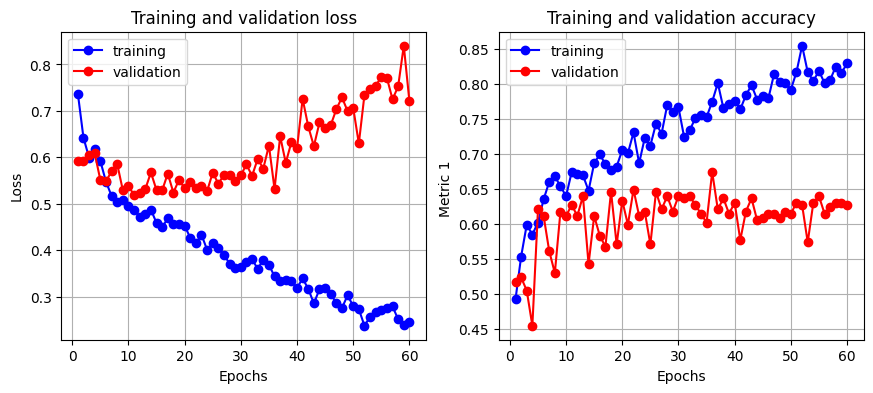

-------------------------------------------------- MODEL PERFORMANCE 2 --------------------------------------------------


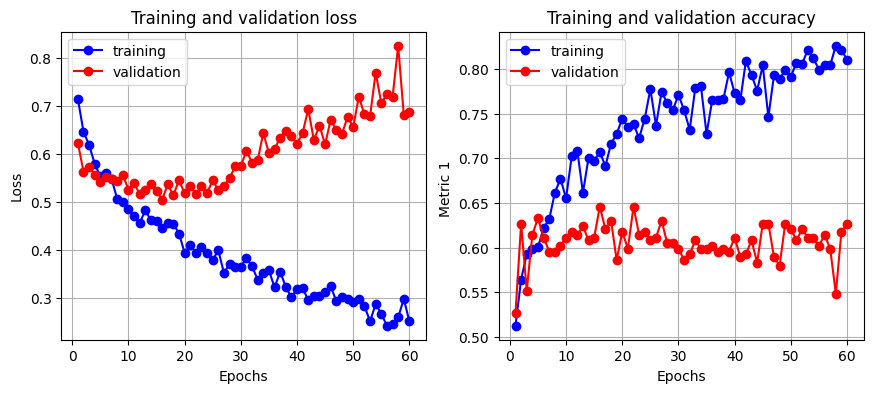

-------------------------------------------------- MODEL PERFORMANCE 3 --------------------------------------------------


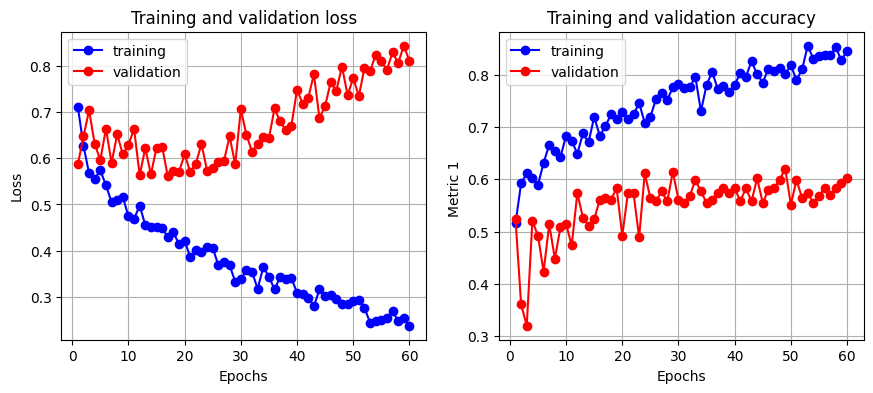

In [ ]:
for i in range(nb_fold):
    print(50*'-',f"MODEL PERFORMANCE {i+1}",50*'-')

    average_loss = list_history[i]['loss']
    average_val_loss = list_history[i]['val_loss']

    average_metric_1 = list_history[i]['accuracy']
    average_val_metric_1 = list_history[i]['val_accuracy']

    plt.figure(figsize=(16,4))

    # Displays model loss and efficiency evolutions for each model
    txtTitres = ["Training and validation loss","Training and validation accuracy"]

    txtYLabel = ["Loss","Metric 1 "]

    L1 = [average_loss, average_metric_1]
    L2 = [average_val_loss, average_val_metric_1]

    for k in range(2):
        if len(L1[0]) < nb_epoch: # to avoid dimension errors when plotting
            nb_epoch_plot=len(L1[0])
        else:
            nb_epoch_plot=nb_epoch
        Epochs = range(1, nb_epoch_plot+1)
        plt.subplot(1,3,k+1)
        plt.plot(Epochs, L1[k], color='b', marker='o', label="training")
        plt.plot(Epochs, L2[k], color='r', marker='o', label="validation")
        plt.grid()
        plt.title(txtTitres[k])
        plt.xlabel("Epochs")
        plt.ylabel(txtYLabel[k])
        plt.legend()
    plt.show()

In [ ]:
# Loading the best model for each fold, our final model will be the "average" of all of them
L_best_models = []
for i in range(nb_fold):
    path = "MODEL/best_model" + str(i+1) + ".hdf5"
    L_best_models.append(keras.models.load_model(path,
                                                 custom_objects={"TFRobertaModel": pretrained_model},
                                                 compile=False))

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

def ConfusionMatrix(y_true , y_pred):
    cm = multilabel_confusion_matrix(y_true , y_pred)
    return cm/y_true.shape[0]

In [ ]:
def metric1(y_true, y_pred):
    n = K.cast(K.shape(y_true)[0], 'float32')
    y_pred_r = K.round(y_pred)
    res = K.all(K.equal(y_true, y_pred_r), axis=1)
    res = K.cast(res, 'float32')
    res = K.sum(res) / n
    return res

In [ ]:
def metric2_per_labels(M): # Takes a matrix containing the absolute difference between true value and prediction
    for i in range(M.shape[1]):
        s = np.sum(M,axis = 0) # Summing per column
        s = 1-s/M.shape[0] # % of good predictions per column
        s = np.round(s,3)
    return s

In [ ]:
L_pred = [np.round(model.predict([X_ids_test, X_mask_test])) for model in L_best_models]
prediction = np.median(L_pred, axis=0) # prediction of final model on test data, that's where nb_fold needs to be odd

cm = ConfusionMatrix(Y_test , prediction)
f1 = f1_score(Y_test , prediction, average=None)
m1 = float(metric1(Y_test, prediction))
m2 = float(metric2(Y_test, prediction))
diff = np.abs(prediction-Y_test)
m3 = metric2_per_labels(diff)

8/8 [==============================] - 5s 256ms/step


---------------------------------------- SUMMARY OF MODEL PERFORMANCE ON TEST DATA -------------------- 

metric1 test mean : 0.4476987421512604 

metric2 test mean : 0.7266387939453125 

metric2 test mean per labels : [0.695 0.695 0.791] 

F1 score on positive/negative/neutral:  [0.58285714 0.657277   0.63235294]


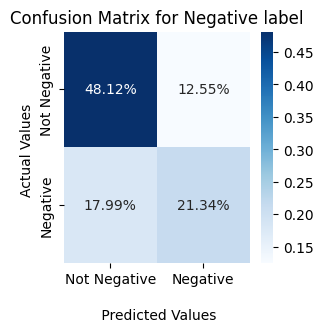

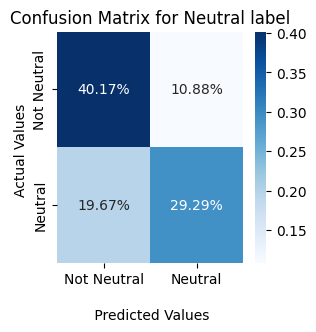

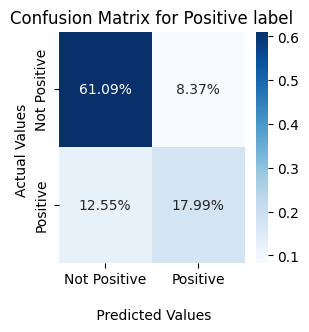

In [ ]:
# Summary of the model's performances on testing data
print(40*'-',f"SUMMARY OF MODEL PERFORMANCE ON TEST DATA",20*'-',"\n")

# metrics
print("metric1 test mean :", m1, "\n")
print("metric2 test mean :", m2, "\n")
print("metric2 test mean per labels :", m3, "\n")

# F1 score
print("F1 score on positive/negative/neutral: ", f1)

# Confusion matrix
L_titles = ['Confusion Matrix for Negative label', 'Confusion Matrix for Neutral label','Confusion Matrix for Positive label']
L_labels = [ 'Not Negative', 'Negative', 'Not Neutral', 'Neutral','Not Positive', 'Positive']

k = 0
for i in range(3):
    plt.figure(figsize=(3,3))
    ax = sns.heatmap(cm[i], annot=True, fmt='.2%' , cmap="Blues")
    ax.set_xlabel('\n Predicted Values')
    ax.set_ylabel('Actual Values ')
    ax.set_title(L_titles[i])
    ax.xaxis.set_ticklabels(L_labels[k:k+2])
    ax.yaxis.set_ticklabels(L_labels[k:k+2])
    k += 2
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, f1_score


print("Classification Report: \n", classification_report(Y_test, prediction,target_names=['Negative','Neutral','Positive']))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.63      0.54      0.58        94
     Neutral       0.73      0.60      0.66       117
    Positive       0.68      0.59      0.63        73

   micro avg       0.68      0.58      0.63       284
   macro avg       0.68      0.58      0.62       284
weighted avg       0.68      0.58      0.63       284
 samples avg       0.63      0.60      0.60       284



In [ ]:
# Computing prediction of final model on validation data, accessible via each fold
L_predictions = []
L_cm = []
L_f1 = []
L_m1, L_m2 = [], []

k = 0

# To evaluate our model which prediction will be the median of all predictions, we'll do an
# average of all scores obtained by each model on their own validation_data
kfold = KFold(n_splits=nb_fold, shuffle=True, random_state=42)
for train_index, val_index in kfold.split(X_ids_train,Y_train):

    prediction = np.argmax(L_best_models[k].predict([X_ids_train[val_index], X_mask_train[val_index]]), axis=1) # prediction for this fold's validation data

    cm = ConfusionMatrix(Y_train[val_index] , prediction)
    f1 = f1_score(Y_train[val_index] , prediction, average=None)
    m1 = metric1(Y_train[val_index], prediction)
    m2 = metric2_per_class(Y_train[val_index] , prediction)

    L_predictions.append(prediction)
    L_cm.append(cm)
    L_f1.append(f1)
    L_m1.append(m1)
    L_m2.append(m2)
    k += 1

---------------------------------------- SUMMARY OF MODEL PERFORMANCE ON VALIDATION DATA -------------------- 

metric1 validation mean : 0.65308255 

metric2 validation mean per class : [0.6961625  0.59347243 0.67060485] 

Average F1 score on positive/negative/neutral:  [0.66042599 0.63424033 0.65726263]


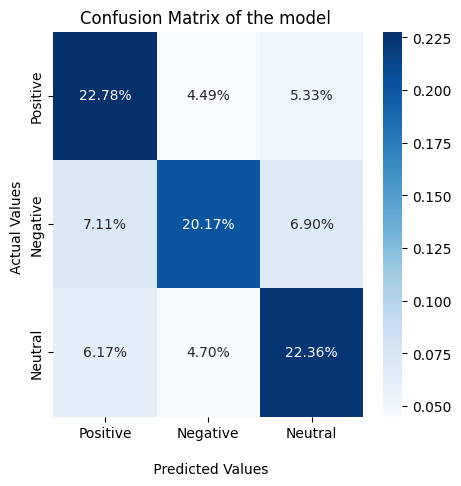

In [ ]:
# Summary of the model's performances on validation data
print(40*'-',f"SUMMARY OF MODEL PERFORMANCE ON VALIDATION DATA",20*'-',"\n")

# Average best metrics
m1 = np.mean(L_m1,axis=0)
m2 = np.mean(L_m2,axis=0)

print("metric1 validation mean :", m1, "\n")
print("metric2 validation mean per class :", m2, "\n")

# Average F1 score
print("Average F1 score on positive/negative/neutral: ", np.mean(L_f1,axis=0))

# Average confusion matrix
avg_cm = np.mean(L_cm,axis=0)
plt.figure(figsize=(5,5))
ax = sns.heatmap(avg_cm, annot=True, fmt='.2%' , cmap="Blues")
ax.set_xlabel('\n Predicted Values')
ax.set_ylabel('Actual Values ')
ax.set_title(f'Confusion Matrix of the model ')
ax.xaxis.set_ticklabels(['Positive', 'Negative' ,'Neutral'])
ax.yaxis.set_ticklabels(['Positive', 'Negative' ,'Neutral'])
plt.show()

# Test

In [ ]:
# Loading pretrained model
pretrained_model = TFAutoModel.from_pretrained(pretrained_model_name)

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
# from sklearn.metrics import multilabel_confusion_matrix

# def ConfusionMatrix(y_true , y_pred):
#     cm = multilabel_confusion_matrix(y_true , y_pred)
#     return cm/y_true.shape[0]

In [ ]:
def metric2_per_labels(M): # Takes a matrix containing the absolute difference between true value and prediction
    for i in range(M.shape[1]):
        s = np.sum(M,axis = 0) # Summing per column
        s = 1-s/M.shape[0] # % of good predictions per column
        s = np.round(s,3)
    return s

In [ ]:
# Loading the best model for each fold, our final model will be the "average" of all of them
L_best_models = []
for i in range(nb_fold):
    path = "MODEL/best_model" + str(i+1) + ".hdf5"
    L_best_models.append(keras.models.load_model(path,
                                                 custom_objects={"TFRobertaModel": pretrained_model,
                                                                 "metric1": metric1,
                                                                 "metric2":metric2},
                                                 compile=False))

In [ ]:
L_pred = [np.round(model.predict([X_ids_test, X_mask_test])) for model in L_best_models]
prediction = np.median(L_pred, axis=0)

predicted_labels = np.argmax(prediction, axis=1).reshape(-1, 1)

8/8 [==============================] - 2s 266ms/step


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, f1_score


print("Classification Report: \n", classification_report(Y_test, predicted_labels,target_names=['Negative','Neutral','Positive']))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.52      0.81      0.63        90
     Neutral       0.81      0.35      0.48        84
    Positive       0.63      0.62      0.62        65

    accuracy                           0.59       239
   macro avg       0.65      0.59      0.58       239
weighted avg       0.65      0.59      0.58       239



In [ ]:
# Computing prediction of final model on test data

L_pred = [np.round(model.predict([X_ids_test, X_mask_test])) for model in L_best_models]
prediction = np.median(L_pred, axis=0) # prediction of final model on test data, that's where nb_fold needs to be odd

predicted_labels = np.argmax(prediction, axis=1).reshape(-1, 1)

cm = ConfusionMatrix(Y_test , predicted_labels)
f1 = f1_score(Y_test , predicted_labels, average=None)
m1 = float(metric1(Y_test, predicted_labels))
m2 = float(metric2(Y_test, predicted_labels))
diff = np.abs(predicted_labels-Y_test)
m3 = metric2_per_labels(diff)

8/8 [==============================] - 2s 262ms/step


In [ ]:
# Summary of the model's performances on testing data
print(40*'-',f"SUMMARY OF MODEL PERFORMANCE ON TEST DATA",20*'-',"\n")

# metrics
print("metric1 validation mean :", m1, "\n")
print("metric2 validation mean :", m2, "\n")
print("metric2 validation mean per labels :", m3, "\n")

# F1 score
print("F1 score on positive/negative/neutral: ", f1)

# Confusion matrix
L_titles = ['Confusion Matrix for Positive label', 'Confusion Matrix for Negative label', 'Confusion Matrix for Neutral label']
L_labels = ['Not Positive', 'Positive', 'Not Negative', 'Negative', 'Not Neutral', 'Neutral']

k = 0
for i in range(3):
    plt.figure(figsize=(3,3))
    ax = sns.heatmap(cm[i], annot=True, fmt='.2%' , cmap="Blues")
    ax.set_xlabel('\n Predicted Values')
    ax.set_ylabel('Actual Values ')
    ax.set_title(L_titles[i])
    ax.xaxis.set_ticklabels(L_labels[k:k+2])
    ax.yaxis.set_ticklabels(L_labels[k:k+2])
    k += 2
    plt.show()